# Installs

In [2]:
# %pip install protobuf==3.20.0
# %pip install urllib3==1.26.6
# %pip install matplotlib==3.5.2
# %pip install pandas==1.3.4
# %pip install statsmodels==0.13.2
# %pip install scikit-learn==1.0.2
# %pip install xgboost==1.6.0
# %pip install catboost==1.0.5
# %pip install deep-forest==0.1.7
# %pip install tensorflow==2.7.0
# %pip install keras-tuner==1.1.2
# %pip install numpy==1.19.5
# %pip install numba==0.55.2
# %pip install shap==0.41.0
# %pip install scikeras==0.12.0
# # %pip install onetick-py

# Imports

In [3]:
# import onetick.py as otp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from statsmodels.tsa.seasonal import STL

from xgboost import XGBRegressor, DMatrix, cv as xgb_cv, callback
from catboost import CatBoostRegressor, Pool, cv as cat_cv, sum_models
from deepforest import CascadeForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
import shap

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
# pd.set_option('display.max_rows', 200)

2023-12-17 21:09:50.940414: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-17 21:09:50.940437: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/otestov/code/ml/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading data

## ETF

In [4]:
# db = 'NYSE_TAQ'
# tick_type = 'TRD'
# symbols = ['QQQ']
# start = otp.dt(2021, 4, 1, 9, 30)
# end = otp.dt(2022, 4, 1, 16, 0)
# bucket = 600  # seconds
# timezone='EST5EDT'

# data = otp.DataSource(db=db, tick_type=tick_type, symbols=symbols)

# data = data.agg({'VOLUME': otp.agg.sum('SIZE')}, bucket_interval = bucket)
# data,_ = data[data['VOLUME'] > 0]

# data['hhmm'] = data['Time'].dt.strftime(format='%H%M')
# data['hhmm'] = data['hhmm'].apply(int)

# etf_ts = otp.run(data,
#                  start=start,
#                  end=end,
#                  apply_times_daily=True,
#                  timezone=timezone).set_index('Time')
# etf_ts

In [5]:
etf_ts = pd.read_csv('./data/etf_nq.csv', index_col='Time')
etf_ts

,VOLUME,hhmm
Time,,
2021-04-01 09:40:00,5787283,940
2021-04-01 09:50:00,3001767,950
2021-04-01 10:00:00,1523707,1000
2021-04-01 10:10:00,3199697,1010
2021-04-01 10:20:00,2662730,1020
...,...,...
2022-04-01 15:20:00,1281702,1520
2022-04-01 15:30:00,1013253,1530
2022-04-01 15:40:00,1386788,1540


## Futures

In [6]:
# db = 'CME'
# tick_type = 'TRD'
# symbols = ['NQ\H21', 'NQ\M21', r'NQ\U21', 'NQ\Z21', 'NQ\H22', 'NQ\M22'] #H M U Z
# start = otp.dt(2021, 4, 1, 9, 30)
# end = otp.dt(2022, 4, 1, 16, 0)
# bucket = 600
# timezone='EST5EDT'

# data = otp.DataSource(db=db, tick_type=tick_type, symbols=symbols)

# data = data.agg({'VOLUME': otp.agg.sum('SIZE')}, bucket_interval = bucket)
# data,_ = data[data['VOLUME'] > 0]

# data['hhmm'] = data['Time'].dt.strftime(format='%H%M')
# data['hhmm'] = data['hhmm'].apply(int)

# fut_ts = otp.run(data,
#                  start=start,
#                  end=end,
#                  apply_times_daily=True,
#                  timezone=timezone).set_index('Time')
# fut_ts

In [7]:
fut_ts = pd.read_csv('./data/fut_nq.csv', index_col='Time')
fut_ts

,VOLUME,hhmm
Time,,
2021-04-01 09:40:00,31967,940
2021-04-01 09:50:00,13194,950
2021-04-01 10:00:00,9774,1000
2021-04-01 10:10:00,26026,1010
2021-04-01 10:20:00,10889,1020
...,...,...
2022-04-01 15:20:00,9723,1520
2022-04-01 15:30:00,9506,1530
2022-04-01 15:40:00,10394,1540


## Options

In [8]:
# db = 'US_OPTIONS'
# tick_type = 'TRD'
# start = otp.dt(2021, 4, 1)
# end = otp.dt(2022, 4, 1)
# bucket = 600
# timezone='EST5EDT'

# data = otp.DataSource(db=db, tick_type=tick_type, identify_input_ts=True)
# data['Date'] = data['Time'].dt.date()

# volume_date = data.agg({'VOLUME': otp.agg.sum('SIZE')}, group_by=['Date'])
# volume_10min = data.agg({'VOLUME': otp.agg.sum('SIZE')}, bucket_interval = bucket)

# all_symbols = otp.Symbols(db='US_OPTIONS', start=start, end=end, keep_db=True, pattern='QQQ%')

# symbols_date = otp.merge([volume_date], symbols=all_symbols, identify_input_ts=True)

# most_traded_by_days = symbols_date.high('VOLUME', n=5, group_by=['Date'])
# most_traded_by_days = otp.run(most_traded_by_days,
#                               start=start,
#                               end=end,
#                               timezone=timezone)

# symbols = list(pd.unique(most_traded_by_days['SYMBOL_NAME']))
# symbols_10min = otp.merge([volume_10min], symbols=symbols)

# symbols_10min['hhmm'] = symbols_10min['Time'].dt.strftime(format='%H%M')
# symbols_10min['hhmm'] = symbols_10min['hhmm'].apply(int)
# symbols_10min['_Time'] = symbols_10min['Time']

# symbols_10min = symbols_10min.agg({'VOLUME': otp.agg.sum('VOLUME'),
#                                    '_Time': otp.agg.first('_Time'),
#                                    'hhmm': otp.agg.first('hhmm')}, 
#                                   group_by = '_Time')

# symbols_10min['Time'] = symbols_10min['_Time']
# symbols_10min = symbols_10min.drop('_Time')
# symbols_10min,_ = symbols_10min[symbols_10min['VOLUME'] > 0]
# symbols_10min,_ = symbols_10min[(symbols_10min['hhmm'] > 930) & (symbols_10min['hhmm'] <= 1600)]

# opt_ts = otp.run(symbols_10min,
#                  start=start,
#                  end=end,
#                  timezone=timezone).set_index('Time')
# opt_ts

In [9]:
opt_ts = pd.read_csv('./data/opt_nq.csv', index_col='Time')
opt_ts

,VOLUME,hhmm
Time,,
2021-04-01 09:40:00,20914,940
2021-04-01 09:50:00,14998,950
2021-04-01 10:00:00,9644,1000
2021-04-01 10:10:00,17938,1010
2021-04-01 10:20:00,12092,1020
...,...,...
2022-03-31 15:20:00,18724,1520
2022-03-31 15:30:00,12523,1530
2022-03-31 15:40:00,18835,1540


## Join raw data together

In [10]:
# specify that we will only use lag values of volumes for the prediction, 
# so we can already begin to explore and preprocess data
columns = ['VOLUME_fut', 'VOLUME_etf', 'VOLUME_opt']
target = 'VOLUME_fut_target'

ts = fut_ts.join(etf_ts, lsuffix='_fut', rsuffix='_etf', how='inner')
ts = ts.join(opt_ts, how='inner')
ts = ts.rename(columns={'VOLUME': 'VOLUME_opt'}).drop(['hhmm_fut', 'hhmm_etf'], axis=1)
ts['VOLUME_fut_target'] = ts['VOLUME_fut']
ts = ts.reset_index()

ts

,Time,VOLUME_fut,VOLUME_etf,VOLUME_opt,hhmm,VOLUME_fut_target
0,2021-04-01 09:40:00,31967,5787283,20914,940,31967
1,2021-04-01 09:50:00,13194,3001767,14998,950,13194
2,2021-04-01 10:00:00,9774,1523707,9644,1000,9774
3,2021-04-01 10:10:00,26026,3199697,17938,1010,26026
4,2021-04-01 10:20:00,10889,2662730,12092,1020,10889
...,...,...,...,...,...,...
9846,2022-03-31 15:20:00,8872,1283681,18724,1520,8872
9847,2022-03-31 15:30:00,12924,1501646,12523,1530,12924
9848,2022-03-31 15:40:00,16582,1970892,18835,1540,16582
9849,2022-03-31 15:50:00,13761,2629317,15626,1550,13761


# Raw data overview

<AxesSubplot:xlabel='Time'>

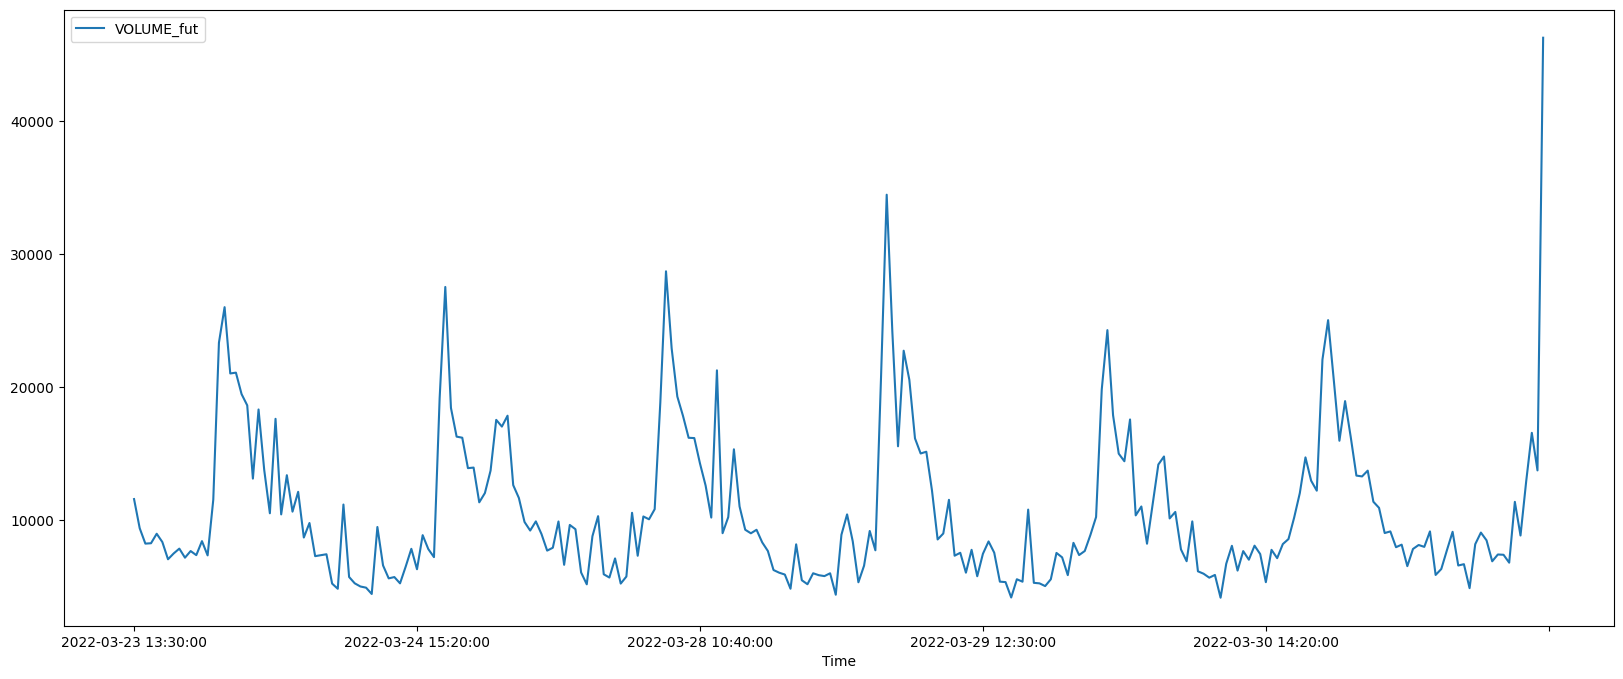

In [11]:
ts.iloc[-250:].plot(y='VOLUME_fut', x='Time', figsize=[20, 8])

## Autocorrelation

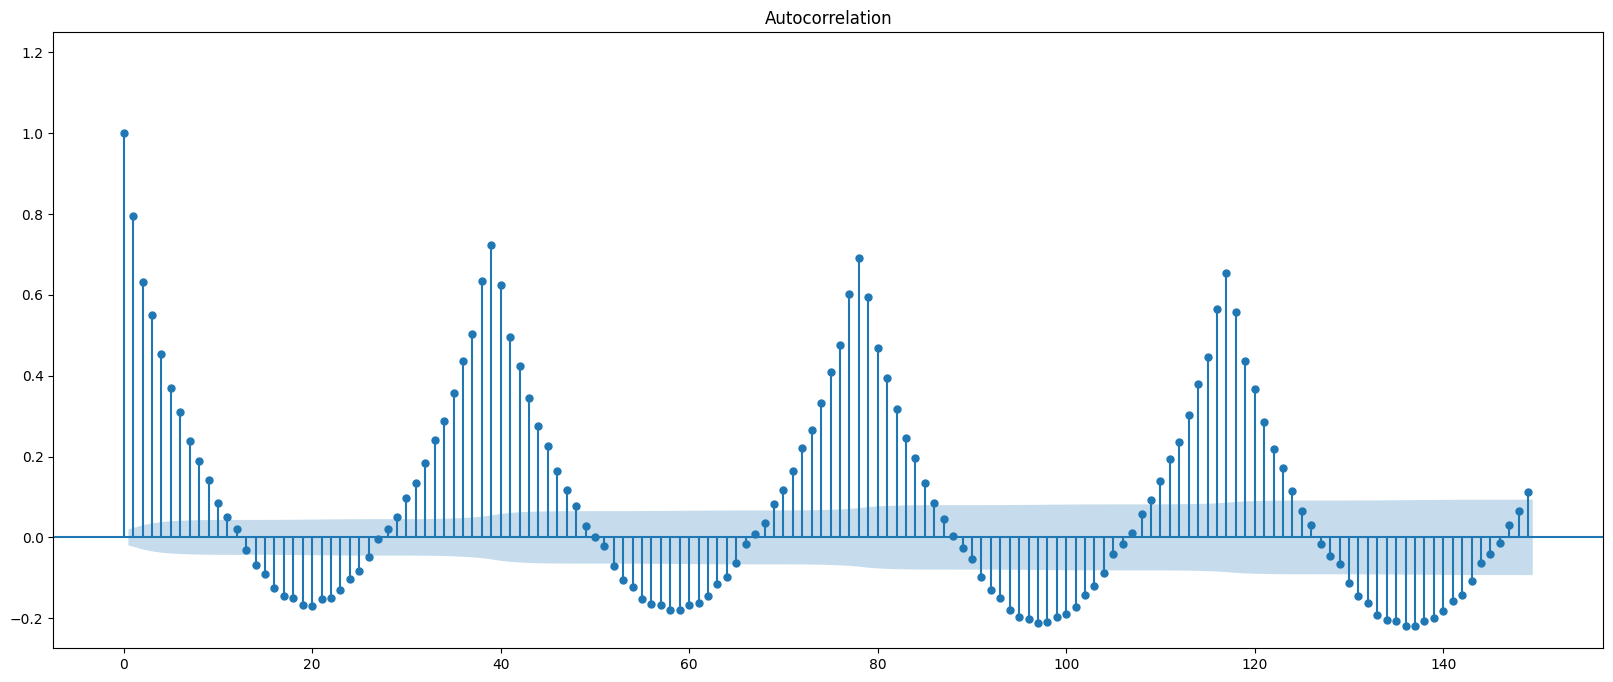

In [12]:
fig, ax = plt.subplots(figsize=(20, 8))
plt_pacf = plot_acf(ts['VOLUME_fut'], ax=ax, lags=np.arange(150), auto_ylims=True)

In [13]:
# fig, ax = plt.subplots(figsize=(20, 8))
# plt_pacf = plot_pacf(ts['VOLUME_fut'], ax=ax, lags=np.arange(200), auto_ylims=True, method='ywm')

# Splitting

In [14]:
test_size = 0.1
val_size = 0.1

test_len = int(ts.shape[0] * test_size)
val_len = int(ts.shape[0] * val_size)
train_len = int(ts.shape[0] - test_len - val_len)

train_indexes = list(range(train_len))
val_indexes = list(range(train_len, train_len + val_len))
test_indexes = list(range(train_len + val_len, ts.shape[0]))

# Preprocessing

## Cap outliers

In [15]:
std_num = 4
means = ts.loc[train_indexes].mean(numeric_only=True)
stds = ts.loc[train_indexes].std(numeric_only=True)
for column in columns:
    up_border = means[column] + std_num * stds[column]
    down_border = max(0, means[column] - std_num * stds[column])
    ts[column] = ts[column].clip(lower=down_border, upper=up_border)

ts

,Time,VOLUME_fut,VOLUME_etf,VOLUME_opt,hhmm,VOLUME_fut_target
0,2021-04-01 09:40:00,31967.000000,4.359291e+06,20914.0,940,31967
1,2021-04-01 09:50:00,13194.000000,3.001767e+06,14998.0,950,13194
2,2021-04-01 10:00:00,9774.000000,1.523707e+06,9644.0,1000,9774
3,2021-04-01 10:10:00,26026.000000,3.199697e+06,17938.0,1010,26026
4,2021-04-01 10:20:00,10889.000000,2.662730e+06,12092.0,1020,10889
...,...,...,...,...,...,...
9846,2022-03-31 15:20:00,8872.000000,1.283681e+06,18724.0,1520,8872
9847,2022-03-31 15:30:00,12924.000000,1.501646e+06,12523.0,1530,12924
9848,2022-03-31 15:40:00,16582.000000,1.970892e+06,18835.0,1540,16582
9849,2022-03-31 15:50:00,13761.000000,2.629317e+06,15626.0,1550,13761


## Consider seasonality

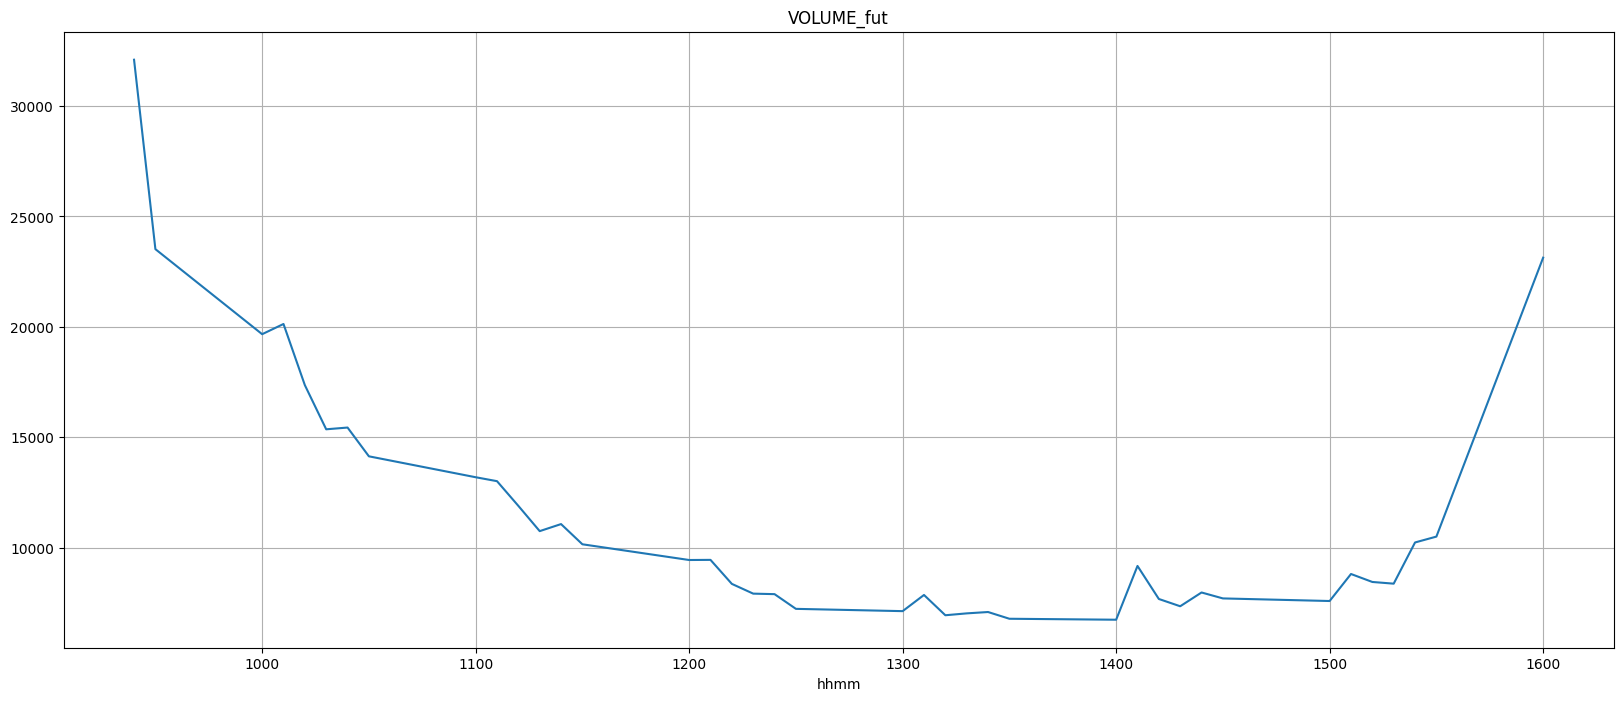

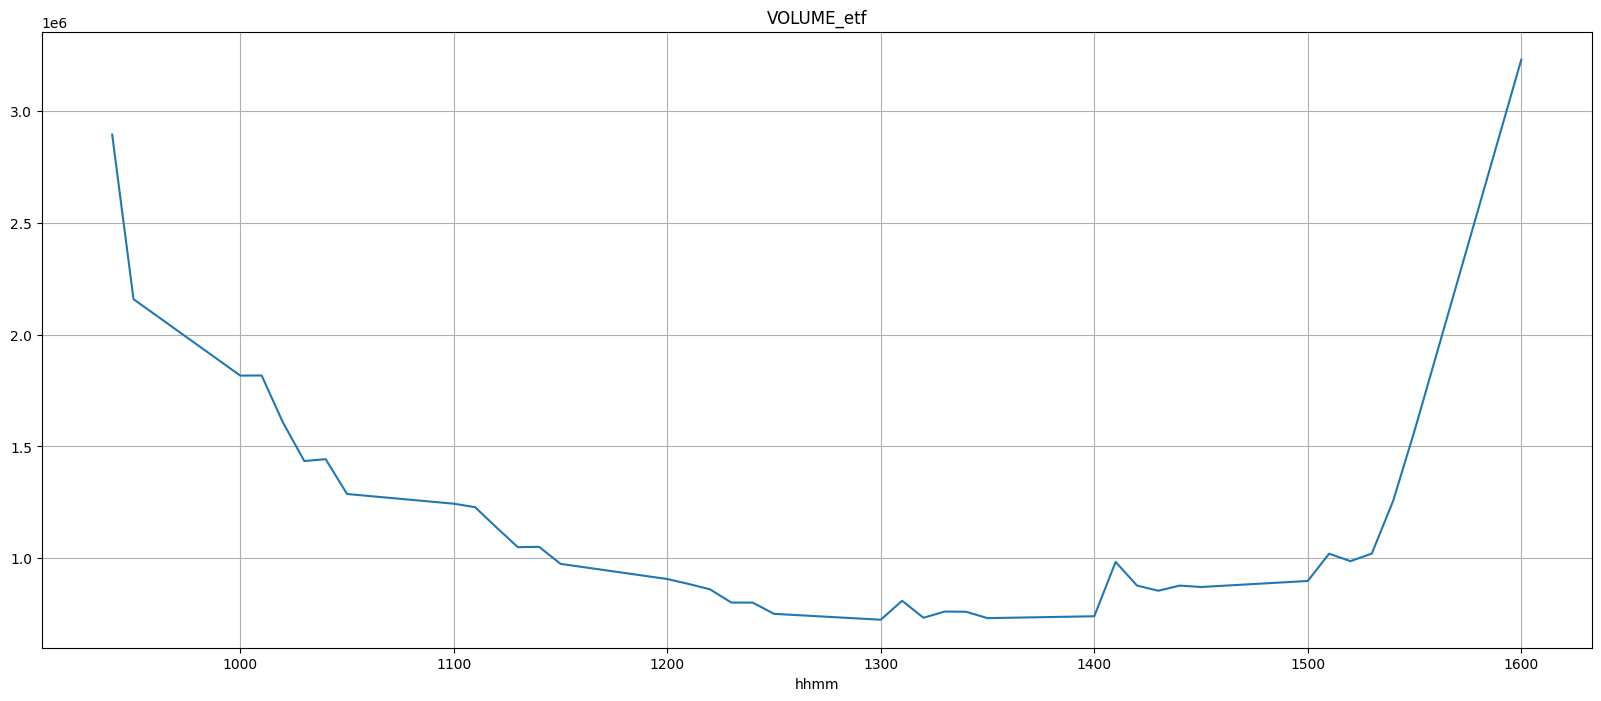

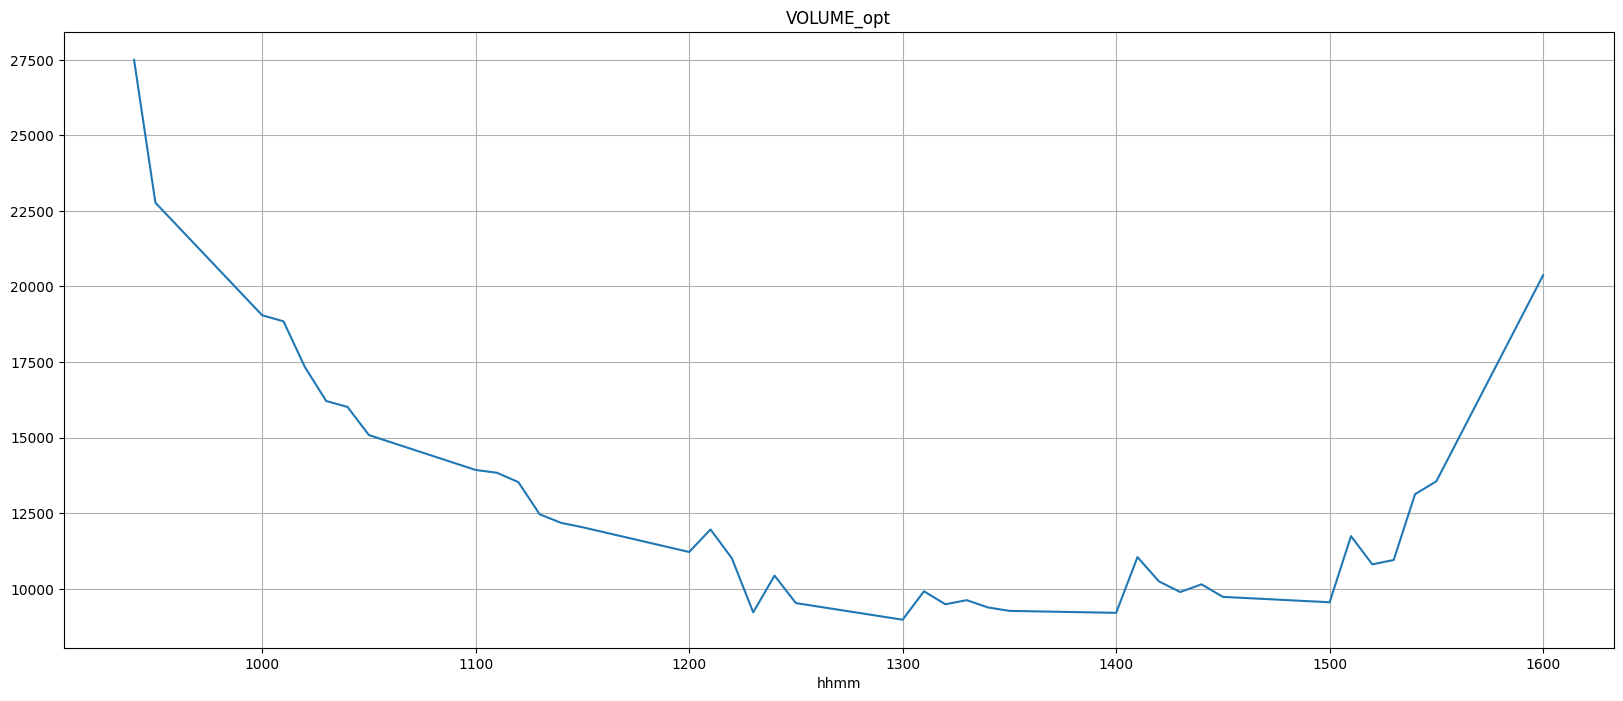

In [16]:
# Average intraday volume profile
ts_agg = ts.groupby('hhmm').mean()

for column in columns:
    fig, ax = plt.subplots(figsize=(20, 8))
    ax = ts_agg[column].plot(ax=ax, title=column)
    ax.grid()

### Apply log + use `hhmm` as a feature

In [17]:
# At the beginning and at the end of the trading session, we see an almost exponential increase in volumes, 
# so using the logarithm will be useful. In addition, using hhmm as a feature will allow the model to take 
# into account the seasonal component in the data.

# Apply log transformation to volumes and add hhmm-feature (further)
ts_log_hhmm = ts.copy()

ts_log_hhmm[columns] = np.log1p(ts_log_hhmm[columns])

ts_log_hhmm

,Time,VOLUME_fut,VOLUME_etf,VOLUME_opt,hhmm,VOLUME_fut_target
0,2021-04-01 09:40:00,10.372491,15.287820,9.948222,940,31967
1,2021-04-01 09:50:00,9.487593,14.914712,9.615739,950,13194
2,2021-04-01 10:00:00,9.187583,14.236657,9.174195,1000,9774
3,2021-04-01 10:10:00,10.166890,14.978567,9.794732,1010,26026
4,2021-04-01 10:20:00,9.295600,14.794863,9.400382,1020,10889
...,...,...,...,...,...,...
9846,2022-03-31 15:20:00,9.090768,14.065243,9.837615,1520,8872
9847,2022-03-31 15:30:00,9.466919,14.222073,9.435402,1530,12924
9848,2022-03-31 15:40:00,9.716133,14.493997,9.843525,1540,16582
9849,2022-03-31 15:50:00,9.529666,14.782235,9.656755,1550,13761


## Scaling

In [18]:
# We will try different models, including DNN so we need to scale data
# should use scaling after removing seasonality!!!
# target_orig for approach 1 and for approach 2 should differ (first with substraction, second without)
# rename target_orig to target
# maybe make a dict where keys are approaches and values are features_columns

# maybe change approaches for loop to function
df = ts_log_hhmm
cols = columns + ['hhmm']

train = df.loc[train_indexes, cols]
val = df.loc[val_indexes, cols]
test = df.loc[test_indexes, cols]

scaler = MinMaxScaler()

df.loc[train_indexes, cols] = scaler.fit_transform(train)
df.loc[val_indexes, cols] = scaler.transform(val)
df.loc[test_indexes, cols] = scaler.transform(test)

df

,Time,VOLUME_fut,VOLUME_etf,VOLUME_opt,hhmm,VOLUME_fut_target
0,2021-04-01 09:40:00,0.924857,1.000000,0.771188,0.000000,31967
1,2021-04-01 09:50:00,0.637925,0.895802,0.699122,0.015152,13194
2,2021-04-01 10:00:00,0.540646,0.706441,0.603418,0.090909,9774
3,2021-04-01 10:10:00,0.858190,0.913635,0.737919,0.106061,26026
4,2021-04-01 10:20:00,0.575670,0.862331,0.652444,0.121212,10889
...,...,...,...,...,...,...
9846,2022-03-31 15:20:00,0.509253,0.658570,0.747214,0.878788,8872
9847,2022-03-31 15:30:00,0.631221,0.702368,0.660035,0.893939,12924
9848,2022-03-31 15:40:00,0.712030,0.778308,0.748495,0.909091,16582
9849,2022-03-31 15:50:00,0.651568,0.858805,0.708013,0.924242,13761


# Lag features

## Add lags

In [19]:
# maybe change approaches for loop to function
# try four last lags, four lags of previous day, four lags of previous week, describe this approach
periods = [1, 2, 3, 4, 38, 39, 78, 195]
lags_columns = []
for column in columns:
    for lag in periods:
        feature_col_name = f'{column}_lag_{lag}'
        df[feature_col_name] = df.shift(lag)[column]
        lags_columns.append(feature_col_name)

df.dropna(inplace=True)
train_indexes = list(set(df.index) & set(train_indexes))

df[lags_columns]

,VOLUME_fut_lag_1,VOLUME_fut_lag_2,VOLUME_fut_lag_3,VOLUME_fut_lag_4,VOLUME_fut_lag_38,VOLUME_fut_lag_39,VOLUME_fut_lag_78,VOLUME_fut_lag_195,VOLUME_etf_lag_1,VOLUME_etf_lag_2,...,VOLUME_etf_lag_78,VOLUME_etf_lag_195,VOLUME_opt_lag_1,VOLUME_opt_lag_2,VOLUME_opt_lag_3,VOLUME_opt_lag_4,VOLUME_opt_lag_38,VOLUME_opt_lag_39,VOLUME_opt_lag_78,VOLUME_opt_lag_195
195,0.696675,0.407792,0.437244,0.309491,0.770878,0.875734,0.855877,0.924857,0.927688,0.468862,...,0.754756,1.000000,0.731842,0.559803,0.536805,0.460971,0.768371,0.903435,0.599747,0.771188
196,0.871158,0.696675,0.407792,0.437244,0.737733,0.770878,0.741665,0.637925,0.798467,0.927688,...,0.638216,0.895802,0.912547,0.731842,0.559803,0.536805,0.815624,0.768371,0.552168,0.699122
197,0.800233,0.871158,0.696675,0.407792,0.723913,0.737733,0.589343,0.540646,0.696246,0.798467,...,0.568715,0.706441,0.808160,0.912547,0.731842,0.559803,0.857828,0.815624,0.477454,0.603418
198,0.693191,0.800233,0.871158,0.696675,0.757375,0.723913,0.683985,0.858190,0.693804,0.696246,...,0.637093,0.913635,0.767403,0.808160,0.912547,0.731842,0.879933,0.857828,0.665385,0.737919
199,0.672374,0.693191,0.800233,0.871158,0.683559,0.757375,0.595451,0.575670,0.584861,0.693804,...,0.517397,0.862331,0.700132,0.767403,0.808160,0.912547,0.733093,0.879933,0.555417,0.652444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9846,0.590540,0.424589,0.451571,0.452530,0.673829,0.608626,0.450609,0.400260,0.790876,0.571865,...,0.686756,0.612849,0.797669,0.655611,0.505390,0.489300,0.678218,0.769648,0.623002,0.632619
9847,0.509253,0.590540,0.424589,0.451571,0.632848,0.673829,0.463739,0.510238,0.658570,0.790876,...,0.830296,0.639003,0.747214,0.797669,0.655611,0.505390,0.621270,0.678218,0.602676,0.762971
9848,0.631221,0.509253,0.590540,0.424589,0.613564,0.632848,0.510857,0.469614,0.702368,0.658570,...,0.744199,0.657796,0.660035,0.747214,0.797669,0.655611,0.700606,0.621270,0.579493,0.623514
9849,0.712030,0.631221,0.509253,0.590540,0.804877,0.613564,0.556442,0.443750,0.778308,0.702368,...,0.819189,0.691303,0.748495,0.660035,0.747214,0.797669,0.703401,0.700606,0.614864,0.577450


## Features importance

In [20]:
features_columns  = lags_columns

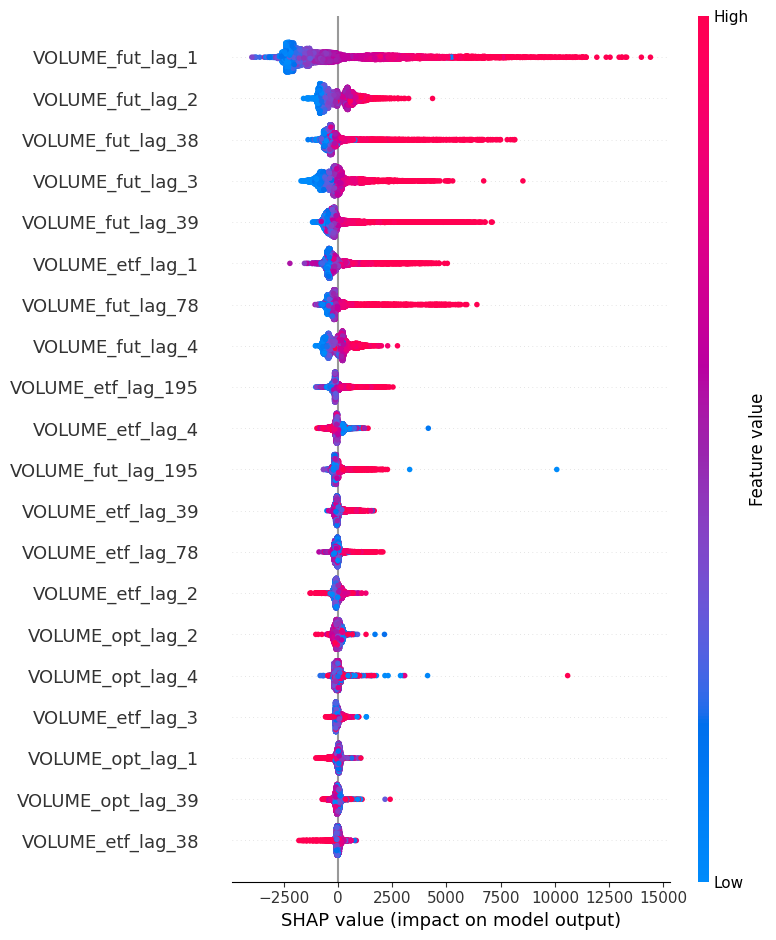

Index(['VOLUME_fut_lag_1', 'VOLUME_fut_lag_2', 'VOLUME_fut_lag_38',
       'VOLUME_fut_lag_3', 'VOLUME_fut_lag_39'],
      dtype='object')

In [21]:
cat = CatBoostRegressor(iterations=1000)
cat.fit(df.loc[train_indexes, features_columns],
        df.loc[train_indexes, target],
        verbose=0,
        plot=False)
explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(df.loc[train_indexes, features_columns])
shap.summary_plot(shap_values, df.loc[train_indexes, features_columns])

# TODO: try 5, 10 and 15 top features
top_num = 5
top_features = pd.DataFrame(shap_values, columns=features_columns).apply(
    lambda x: abs(x)).sum().sort_values(ascending=False)[:top_num].index
top_features

# Training - Prediction

In [22]:
top_features = top_features

In [23]:
x_train, x_val, x_test = df.loc[train_indexes, top_features], df.loc[val_indexes, top_features], df.loc[test_indexes, top_features]
y_train, y_val, y_test = df.loc[train_indexes, target], df.loc[val_indexes, target], df.loc[test_indexes, target]

In [24]:
x_train

,VOLUME_fut_lag_1,VOLUME_fut_lag_2,VOLUME_fut_lag_38,VOLUME_fut_lag_3,VOLUME_fut_lag_39
195,0.696675,0.407792,0.770878,0.437244,0.875734
196,0.871158,0.696675,0.737733,0.407792,0.770878
197,0.800233,0.871158,0.723913,0.696675,0.737733
198,0.693191,0.800233,0.757375,0.871158,0.723913
199,0.672374,0.693191,0.683559,0.800233,0.757375
...,...,...,...,...,...
7876,0.642561,0.691592,0.574447,0.740575,0.531529
7877,0.627994,0.642561,0.521340,0.691592,0.574447
7878,0.639738,0.627994,0.538983,0.642561,0.521340
7879,0.656478,0.639738,0.581864,0.627994,0.538983


In [25]:
y_train

195     27088
196     21766
197     15646
198     14673
199     10433
        ...  
7876    12796
7877    13268
7878    13971
7879     9952
7880     8885
Name: VOLUME_fut_target, Length: 7686, dtype: int64

## Baseline model (current prediction = previous actual)

In [26]:
tdf = ts.copy(deep=True)
tdf['VOLUME_prediction'] = tdf[target].shift(1)
tdf.loc[tdf['hhmm']==940, 'VOLUME_prediction'] = tdf.loc[tdf['hhmm']==940, target].shift(1)
tdf.loc[tdf['hhmm']==1600, 'VOLUME_prediction'] = tdf.loc[tdf['hhmm']==1600, target].shift(1)

tdf_test = tdf.loc[test_indexes]

r2_baseline = r2_score(tdf_test[target], tdf_test['VOLUME_prediction'])
mae_baseline = mean_absolute_error(tdf_test[target], tdf_test['VOLUME_prediction'])
mape_baseline = mean_absolute_percentage_error(tdf_test[target], tdf_test['VOLUME_prediction'])

print("MAE baseline:", mae_baseline)
print("R2 baseline:", r2_baseline)
print("MAPE baseline:", mape_baseline)

MAE baseline: 2708.410152284264
R2 baseline: 0.632815109907548
MAPE baseline: 0.2167638107543498


## Simple models

### Determine models

In [27]:
xgb = XGBRegressor()
cat = CatBoostRegressor()
cfr = CascadeForestRegressor()
# lgmb = LGBMRegressor()

# Adapt tensorflow MLP model to sklearn API

# TODO: move imports to the top

from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential

from scikeras.wrappers import KerasRegressor

def dnn(meta, compile_kwargs, **kwargs):
        model = Sequential()
        model.add(Input(shape=(meta['n_features_in_'])))
        for layer in range(1, kwargs.get('hid_layers_num', 2) + 1):
            model.add(Dense(kwargs.get(f'neurons_num_layer{layer}', 4),
                            activation=kwargs.get(f'activation_layer{layer}', 'relu')))
            if kwargs.get(f'dropout_layer{layer}', 0) > 0:
                model.add(Dropout(kwargs[f'dropout_layer{layer}']))
        model.add(Dense(1))
        model.compile(loss=compile_kwargs["loss"],
                      optimizer=compile_kwargs["optimizer"])
        return model

dnn = KerasRegressor(
    model=dnn,
    loss='mean_squared_error',
    optimizer='adam',
    hid_layers_num=2,
    neurons_num_layer1=4,
    activation_layer1='relu',
    dropout_layer1=0,
    neurons_num_layer2=4,
    activation_layer2='relu',
    dropout_layer2=0,
    batch_size=32,
    epochs=3,
    verbose=0
)

### Models parameters

In [28]:
models = {
    'xgboost': {
        'class': xgb, 
        'init_params': {
            'n_estimators': [100, 500], 
            'max_depth': [3, 4], 
            'learning_rate': [0.1], 
            'verbosity': [0],
            'n_jobs': [4]
            },
        'fit_params': {'verbose': False}
        },
    'catboost': {
        'class': cat, 
        'init_params': {
            'iterations': [100, 500],
            'depth': [3, 4],
            'learning_rate': [0.1],
            'verbose': [0]
            },
        'fit_params': {'verbose': False}
        },
    'cascadeforest': {
        'class': cfr,
        'init_params': {
            # 'n_estimators': [3],
            'n_trees': [100, 500],
            'max_depth': [3, 4],
            # 'max_layers': [5],
            # 'use_predictor': [True],
            'verbose': [0],
            'n_jobs': [4]
            },
        'fit_params': {}
    },
    'dnn': {
        'class': dnn,
        'init_params': {
            'hid_layers_num': [2],
            'neurons_num_layer1': [28, 32],
            'activation_layer1': ['relu'],
            'dropout_layer1': [0],
            'neurons_num_layer2': [28, 32],
            'activation_layer2': ['relu'],
            'dropout_layer2': [0],
            'batch_size': [32],
            'epochs': [100],
            'verbose': [0]
            },
        'fit_params': {'verbose': False}
    }
}

### Determine metrics

In [29]:
# TODO: move imports to the top

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from deepforest import CascadeForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

### GSCV

In [30]:
sklearn_params = dict(
                scoring={
                    'MAE': mae_scorer, 
                    'R2': r2_scorer, 
                    'MAPE': mape_scorer
                },
                cv=10,
                refit='MAE',
                verbose=False,
                n_jobs=10,
            )

best_estimators = {}
for model_name, model_params in models.items():
    print(f"Training {model_name}...")
    gscv = GridSearchCV(
        model_params['class'],
        model_params['init_params'],
        **sklearn_params
    )
    # TODO: try to add here: with parallel_backend('loky', n_jobs=10):
    gscv.fit(
        pd.concat([x_train, x_val]),
        np.ravel(pd.concat([y_train, y_val])),
        **model_params['fit_params']
    )
    # print(pd.DataFrame(gscv.cv_results_)[['params', 'mean_test_score', 'std_test_score']])
    print("Best mean test score:", gscv.best_score_)
    best_estimators[model_name] = gscv.best_estimator_

Training xgboost...


Best mean test score: -2292.7843574125427
Training catboost...
Best mean test score: -2273.484616130984
Training cascadeforest...
Best mean test score: -2377.717534973685
Training dnn...


2023-12-17 21:12:16.577522: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-17 21:12:16.577545: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-17 21:12:16.578884: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-17 21:12:16.578908: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-17 21:12:16.580027: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or dire

Best mean test score: -2807.783367696964


### Evaluation

In [31]:
# TODO: pack inverse transform to a function and apply it to all models

for model_name, estimator in best_estimators.items():
    y_pred = pd.DataFrame(estimator.predict(x_test), index=x_test.index, columns=['VOLUME_prediction'])
    
    # TODO: remove copy
    tdf_test = y_pred.join(df)[['VOLUME_prediction', 'VOLUME_fut_target']].copy(deep=True)
    tdf_test['VOLUME_original'] = tdf_test['VOLUME_fut_target']
    
    mae = mean_absolute_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
    r2 = r2_score(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
    mape = mean_absolute_percentage_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
    
    print(f"\n{model_name} metrics:")
    print("MAE:", mae)
    print("R2:", r2)
    print("MAPE:", mape)
    print('-'*40)


xgboost metrics:
MAE: 2310.2758144630393
R2: 0.7254845350834104
MAPE: 0.1908271990324241
----------------------------------------

catboost metrics:
MAE: 2326.924866037495
R2: 0.7245276088066729
MAPE: 0.19216833227665173
----------------------------------------



cascadeforest metrics:
MAE: 2322.2380207597043
R2: 0.7178783365659365
MAPE: 0.19164477204547126
----------------------------------------

dnn metrics:
MAE: 2622.8449679766813
R2: 0.6685110406362449
MAPE: 0.2256104868827296
----------------------------------------


## Ensemble models

### XGBoost

In [35]:
class SaveBestModel(callback.TrainingCallback):
    def __init__(self, cvboosters):
        self._cvboosters = cvboosters

    def after_training(self, model):
        self._cvboosters[:] = [cvpack.bst for cvpack in model.cvfolds]
        return model


param_grid = {'max_depth': [1], 'min_child_weight': [1], 'learning_rate': [0.09],
              'models_num': [10], 'early_stopping_rounds': [30]}

for params in ParameterGrid(param_grid):

    tscv = TimeSeriesSplit(n_splits=params['models_num'])
    cv_index_list = []
    for cv_train_index, cv_val_index in tscv.split(pd.concat([x_train, x_val])):
        cv_index_list.append((cv_train_index, cv_val_index))

    cv_models = []
    xgb_params = {
        # 'nthread': 4,
        # 'n_estimators': 500,
        'max_depth': params['max_depth'],
        'min_child_weight': params['min_child_weight'],
        'learning_rate': params['learning_rate']}

    data_dmatrix = DMatrix(data=pd.concat([x_train, x_val]), label=pd.concat([y_train, y_val]))

    # maybe use mse?
    cv_results = xgb_cv(dtrain=data_dmatrix, params=xgb_params, folds=cv_index_list, num_boost_round=500,
                        early_stopping_rounds=params['early_stopping_rounds'], metrics="mae", as_pandas=True,
                        seed=0, shuffle=False, callbacks=[SaveBestModel(cv_models)])
    print(params)
    print(cv_results['test-mae-mean'].min())

MAE/StdDev 32.90735572866131
R2, MAE, MAPE:
0.7695877910075168 2195.956998016342 0.18586190560772214


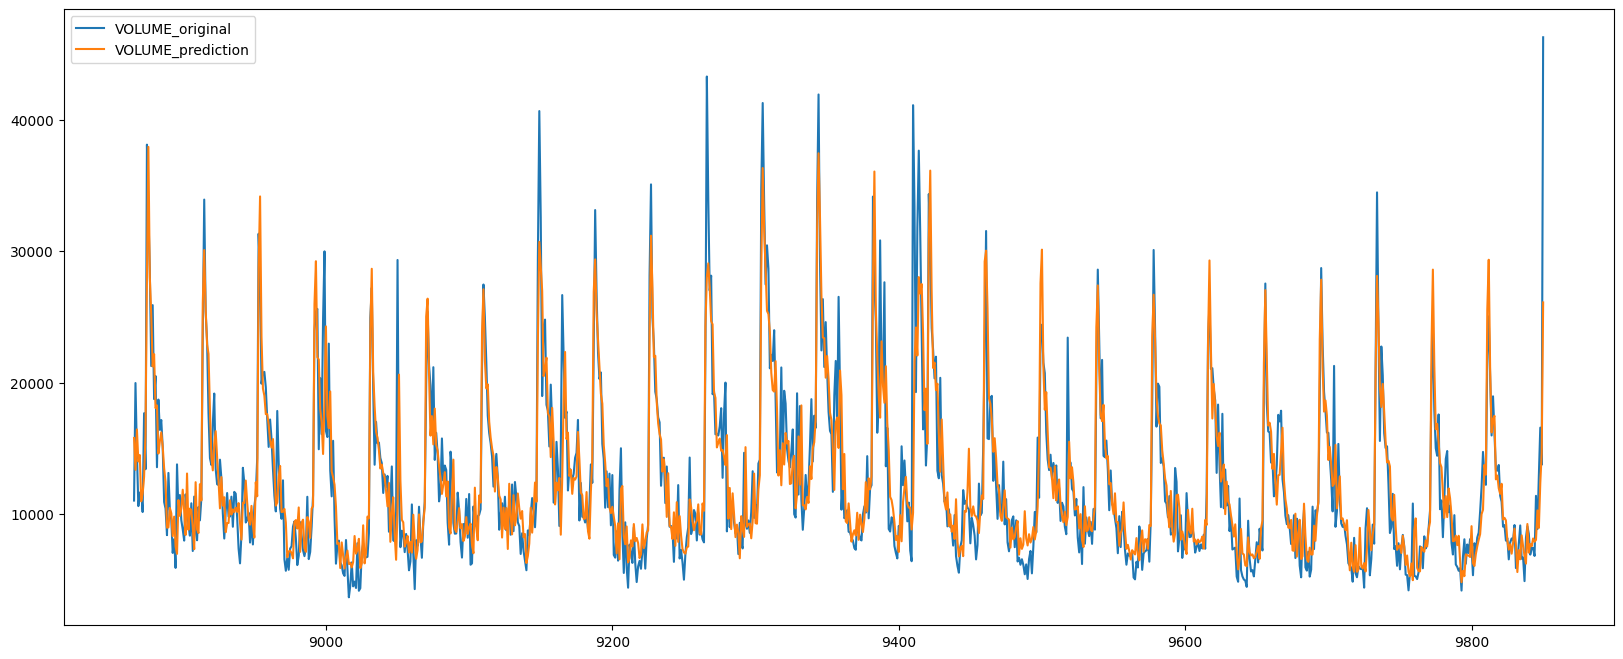

In [ ]:
# prediction_xgb = pd.DataFrame(xgb.predict(x_test), index=x_test.index, columns=['prediction'])

prediction_xgb = pd.DataFrame(
    pd.concat([pd.DataFrame(xgb.predict(DMatrix(x_test)), index=x_test.index) for xgb in cv_models],
              axis=1).mean(axis=1), columns=['VOLUME_prediction'])

if df is ts_int_avg:
        tdf_test = int_avg_inverse_transform(prediction_xgb, df)

tdf_test['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

std_orig = tdf_test.std(numeric_only=True)['VOLUME_original']
r2_xgb = r2_score(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mae_xgb = mean_absolute_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mape_xgb = mean_absolute_percentage_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])

print('MAE/StdDev', mae_xgb / std_orig * 100)
print('R2, MAE, MAPE:')
print(r2_xgb, mae_xgb, mape_xgb)

<AxesSubplot:>

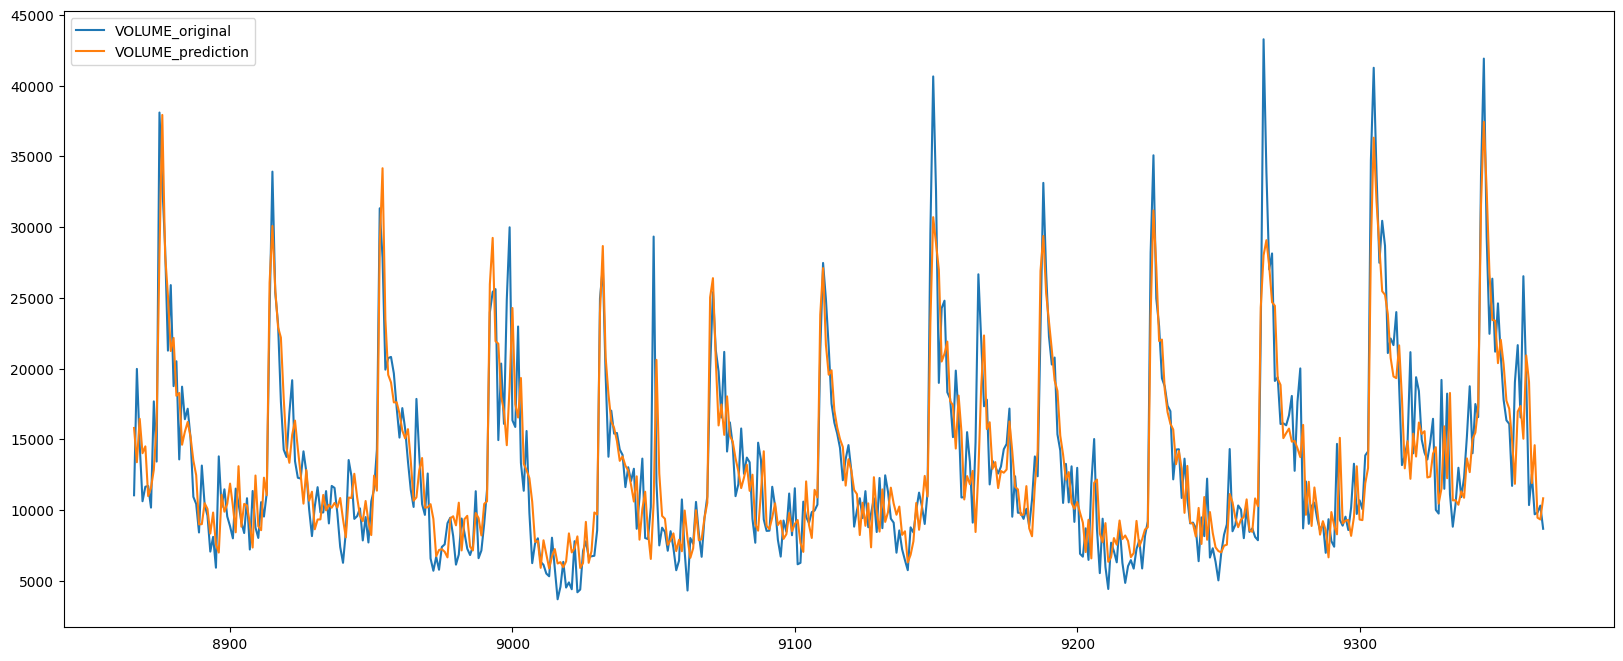

In [ ]:
tdf_test.iloc[:500]['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test.iloc[:500]['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

### CatBoost

In [ ]:
param_grid = {'depth': [2], 'l2_leaf_reg': [3], 'learning_rate': [0.09], 'models_num': [10],
              'early_stopping_rounds': [30]}
for params in ParameterGrid(param_grid):
    models_num = params['models_num']
    cv_dataset = Pool(data=pd.concat([x_train, x_val]), label=pd.concat([y_train, y_val]))

    # maybe use MSE?
    cat_params = {"iterations": 500,
                  "depth": params['depth'],
                  "l2_leaf_reg": params['l2_leaf_reg'],
                  "learning_rate": params['learning_rate'],
                  "loss_function": "MAE",
                  "custom_metric": 'R2',
                  # "eval_metric": 'BalancedAccuracy',
                  "use_best_model": True,
                  "verbose": False}

    res = cat_cv(cv_dataset,
                 cat_params,
                 fold_count=models_num,
                 shuffle=False,
                 early_stopping_rounds=params['early_stopping_rounds'],
                 type='TimeSeries',
                 return_models=True,
                 plot=False,
                 logging_level='Silent')
    print(params)
    print(res[0]['test-MAE-mean'].min())

{'depth': 2, 'early_stopping_rounds': 30, 'l2_leaf_reg': 3, 'learning_rate': 0.09, 'models_num': 10}
2094.8701215198016


MAE/StdDev 32.10609837831757
R2, MAE, MAPE:
0.7629795586352154 2142.4878982744 0.17289897562104875


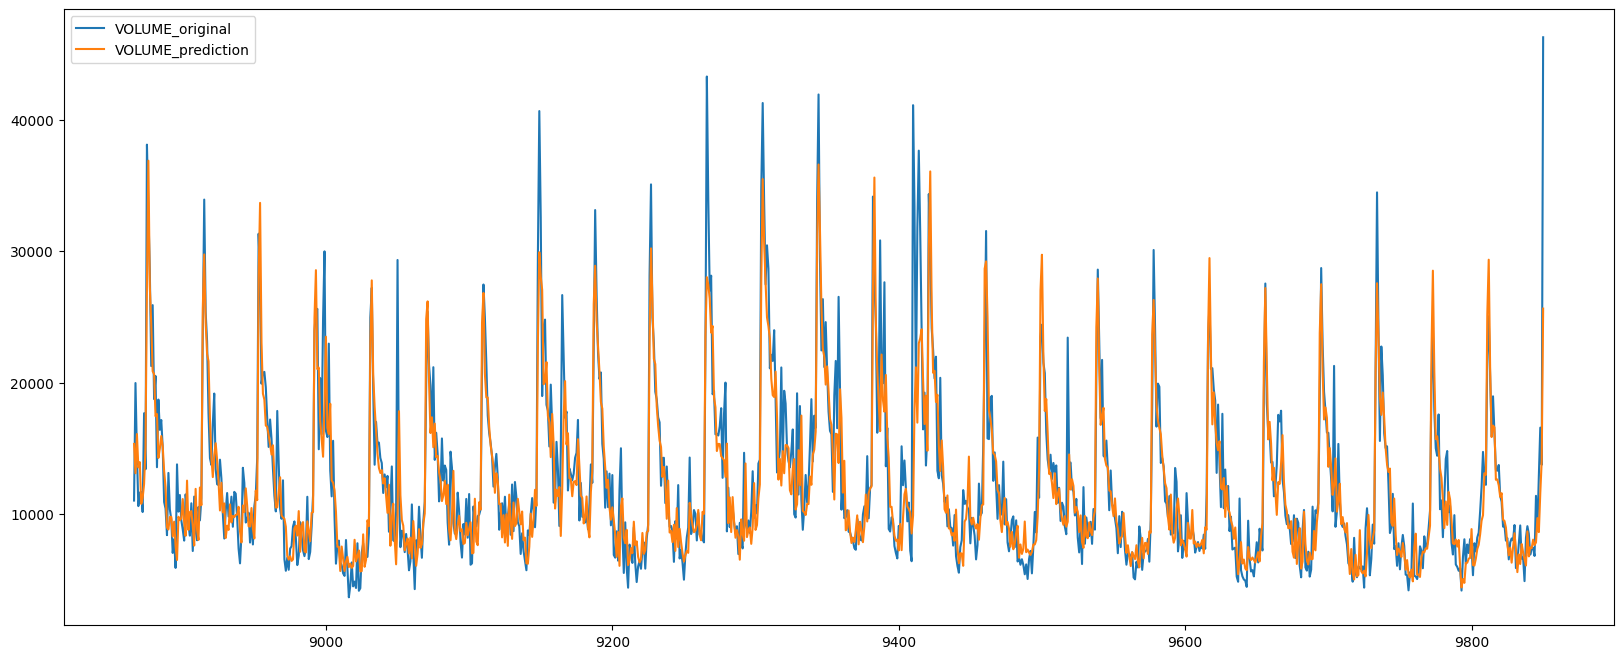

In [ ]:
cat = sum_models(res[1], [1 / models_num] * models_num)

prediction_cat = pd.DataFrame(cat.predict(x_test), index=x_test.index, columns=['VOLUME_prediction'])

if df is ts_int_avg:
        tdf_test = int_avg_inverse_transform(prediction_cat, df)

tdf_test['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

std_orig = tdf_test.std(numeric_only=True)['VOLUME_original']
r2_cat = r2_score(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mae_cat = mean_absolute_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mape_cat = mean_absolute_percentage_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])

print('MAE/StdDev', mae_cat / std_orig * 100)
print('R2, MAE, MAPE:')
print(r2_cat, mae_cat, mape_cat)

<AxesSubplot:>

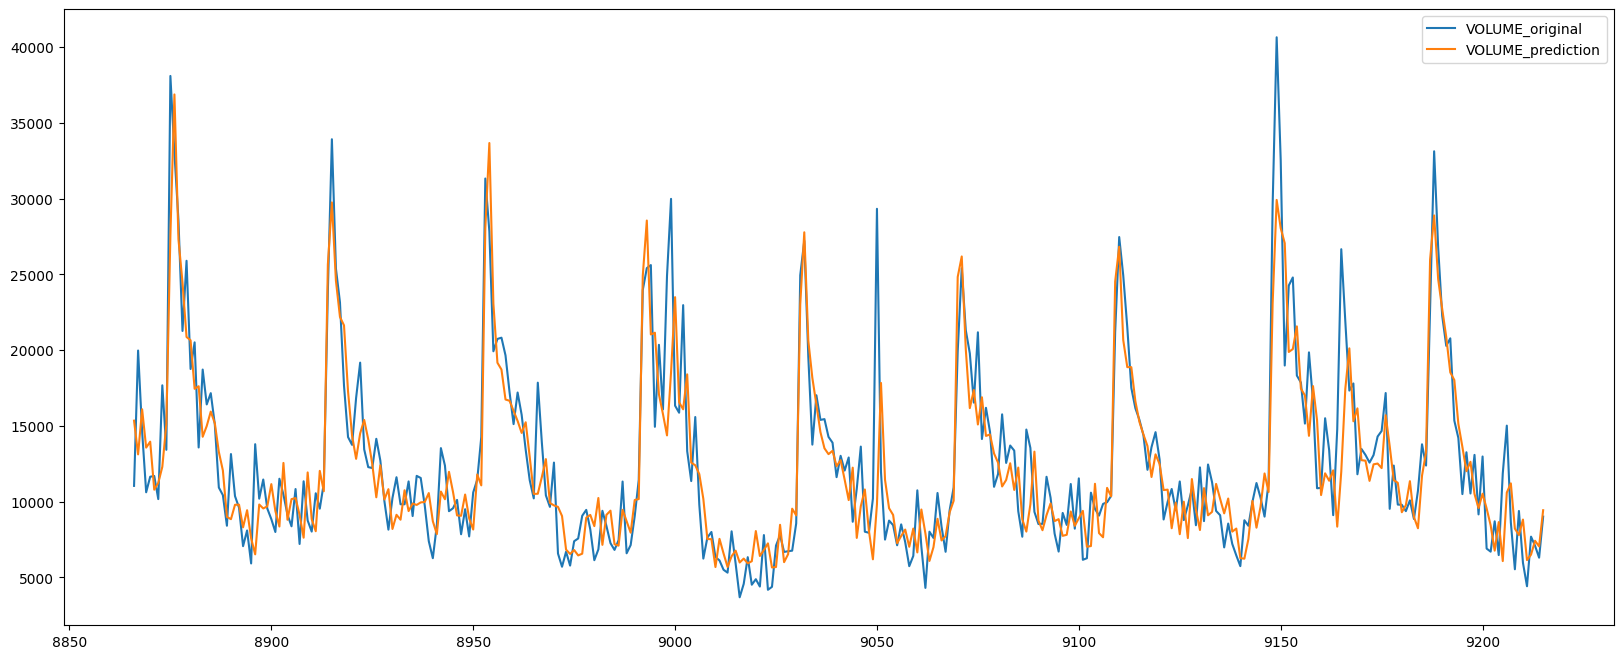

In [ ]:
tdf_test.iloc[:350]['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test.iloc[:350]['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

### DNN

In [ ]:
class TSCVTuner(kt.engine.tuner.Tuner):
    def on_search_begin(self):
        super().on_search_begin()
        self.results = {}
        self.results['trials'] = []
        self.results['models'] = []
        self.results['metrics'] = []
        self.results['params'] = []

    def run_trial(self, trial, x, y, **kwargs):
        hp = trial.hyperparameters
        tscv = TimeSeriesSplit(5)
        val_losses = []
        shift = x.index[0]
        for train_indices, test_indices in tscv.split(x):
            train_indices += shift
            test_indices += shift
            x_train_cv, x_test_cv = x.loc[train_indices], x.loc[test_indices]
            y_train_cv, y_test_cv = y.loc[train_indices], y.loc[test_indices]
            model = self.hypermodel.build(hp)
            history = model.fit(x_train_cv, y_train_cv, validation_data=(x_test_cv, y_test_cv), **kwargs)
            metric = model.evaluate(x_test_cv, y_test_cv, verbose=0)
            val_losses.append(metric)
            self.save_model(trial.trial_id, model, metric, str(hp.get_config()['values']))

        print(hp.get_config()['values'], 'metric value:', np.mean(val_losses))
        self.oracle.update_trial(trial.trial_id, {'val_loss': np.mean(val_losses)})

        return {'val_loss': np.mean(val_losses)}

    def save_model(self, trial_id, model, metric, params, step=0):
        # if params not in self.results.keys():
        #     self.results[params] = {}
        #     self.results[params]['models'] = []
        #     self.results[params]['metrics'] = []
        # self.results[params]['models'].append(model)
        # self.results[params]['metrics'].append(metric)
        self.results['trials'].append(trial_id)
        self.results['models'].append(model)
        self.results['metrics'].append(metric)
        self.results['params'].append(params)


class DNN(kt.HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Dense(units=hp.Choice('units1', [28, 32]), activation=hp.Choice('activation1', ['relu'])))
        # model.add(Dropout(hp.Choice('drop1', [0.0, 0.1, 0.5])))
        model.add(Dense(units=hp.Choice('units2', [28, 32]), activation=hp.Choice('activation2', ['relu'])))
        # model.add(Dropout(hp.Choice('drop2', [0.0, 0.1, 0.5])))
        model.add(Dense(1))

        model.compile(loss='mean_squared_error', optimizer='RMSprop')
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            epochs=hp.Choice('epochs', [1024]),
            batch_size=hp.Choice('batch_size', [32]),
            shuffle=False,
            verbose=0,
            **kwargs
        )


tuner = TSCVTuner(
    oracle=kt.oracles.RandomSearch(
        objective='val_loss',
        max_trials=10),
    hypermodel=DNN(),
    directory='./dnn_checkpoints/',
    overwrite=True
)

early_stopping = EarlyStopping(monitor='val_loss', patience=32, restore_best_weights=True)
tuner.search(pd.concat([x_train, x_val]), pd.concat([y_train, y_val]), batch_size=32, epochs=1024, shuffle=False,
             verbose=0, callbacks=[early_stopping])

{'units1': 32, 'activation1': 'relu', 'units2': 32, 'activation2': 'relu'} metric value: 10064647.5
{'units1': 32, 'activation1': 'relu', 'units2': 28, 'activation2': 'relu'} metric value: 10113114.5
{'units1': 28, 'activation1': 'relu', 'units2': 28, 'activation2': 'relu'} metric value: 10077141.7
{'units1': 28, 'activation1': 'relu', 'units2': 32, 'activation2': 'relu'} metric value: 10073170.0
INFO:tensorflow:Oracle triggered exit


In [ ]:
min_index = pd.DataFrame(tuner.results).groupby(['trials']).mean().idxmin()
dnn_models = pd.DataFrame(tuner.results).set_index('trials').loc[min_index['metrics']]['models'].values

In [ ]:
# remove this cell, but use dnn with gscv like in dsf
# class DNN(kt.HyperModel):
#     def build(self, hp):
#         from tensorflow.keras.models import Sequential
#         from tensorflow.keras.layers import Dense, Dropout
#
#         model = Sequential()
#         model.add(Dense(units=hp.Choice('units1', [24, 28, 32]), activation = hp.Choice('activation1', ['relu'])))
#         # model.add(Dropout(hp.Choice('drop1', [0.0, 0.1, 0.5])))
#         model.add(Dense(units=hp.Choice('units2', [12, 16, 20, 24, 28, 32]), activation = hp.Choice('activation2', ['relu'])))
#         # model.add(Dropout(hp.Choice('drop2', [0.0, 0.1, 0.5])))
#         model.add(Dense(1))
#
#         model.compile(loss = 'mean_squared_error', optimizer = 'RMSprop')
#         return model
#
#     def fit(self, hp, model, *args, **kwargs):
#         return model.fit(
#             *args,
#             epochs=hp.Choice('epochs', [1024]),
#             batch_size=hp.Choice('batch_size', [32]),
#             shuffle=False,
#             verbose=0,
#             **kwargs
#         )
#
# tuner = kt.RandomSearch(
#     DNN(),
#     objective='val_loss',
#     max_trials = 18,
#     directory='./dnn_checkpoints/',
#     overwrite=True,
# )
# early_stopping = EarlyStopping(monitor='val_loss', patience=32, restore_best_weights=True)
# tuner.search(x_train, y_train, validation_data=(x_val, y_val), callbacks=[early_stopping])

# tuner.results_summary()

In [ ]:
# mae_dnn = []
# for i in range(1,11):
#     dnn_models = tuner.get_best_models(num_models=i)
#
#     prediction_dnn = pd.DataFrame(pd.concat([pd.DataFrame(dnn.predict(x_val), index=x_val.index) for dnn in dnn_models], axis=1).mean(axis=1), columns=['prediction'])
#
#     tdf_val = prediction_dnn.join(df)[['prediction','VOLUME_fut_agg', 'VOLUME_fut']].copy(deep=True)
#     tdf_val['VOLUME_prediction'] = tdf_val['prediction'] + tdf_val['VOLUME_fut_agg']
#     tdf_val['VOLUME_original'] = tdf_val['VOLUME_fut'] + tdf_val['VOLUME_fut_agg']
#
#     mae_dnn.append(mean_absolute_error(tdf_val['VOLUME_original'], tdf_val['VOLUME_prediction']))
# dnn_models = tuner.get_best_models(num_models=np.argmin(mae_dnn)+1)

MAE/StdDev 32.939523680973544
R2, MAE, MAPE:
0.7702927582785244 2198.1036135200115 0.18668045813152065


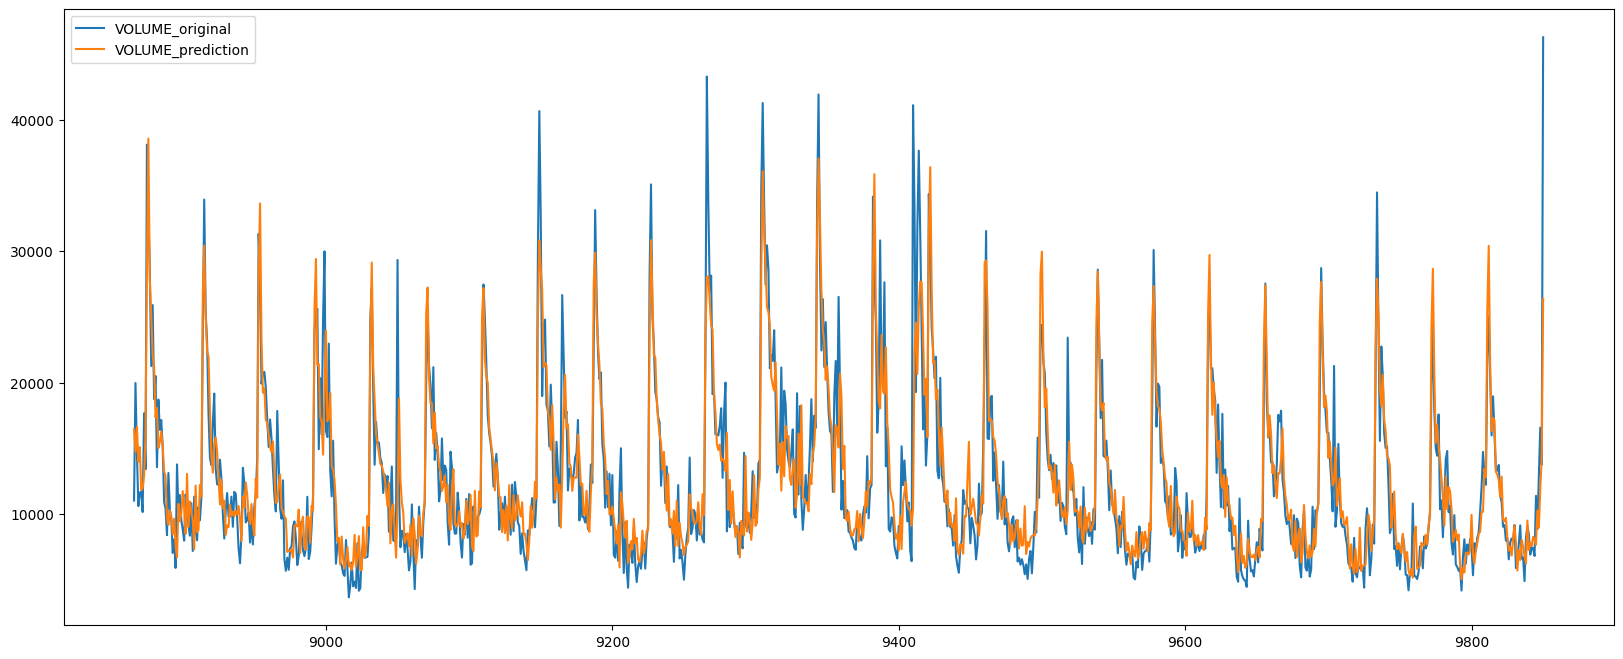

In [ ]:
prediction_dnn = pd.DataFrame(
    pd.concat([pd.DataFrame(dnn.predict(x_test), index=x_test.index) for dnn in dnn_models], axis=1).mean(axis=1),
    columns=['VOLUME_prediction'])

if df is ts_int_avg:
        tdf_test = int_avg_inverse_transform(prediction_dnn, df)

tdf_test['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

std_orig = tdf_test.std(numeric_only=True)['VOLUME_original']
r2_dnn = r2_score(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mae_dnn = mean_absolute_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mape_dnn = mean_absolute_percentage_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])

print('MAE/StdDev', mae_dnn / std_orig * 100)
print('R2, MAE, MAPE:')
print(r2_dnn, mae_dnn, mape_dnn)

<AxesSubplot:>

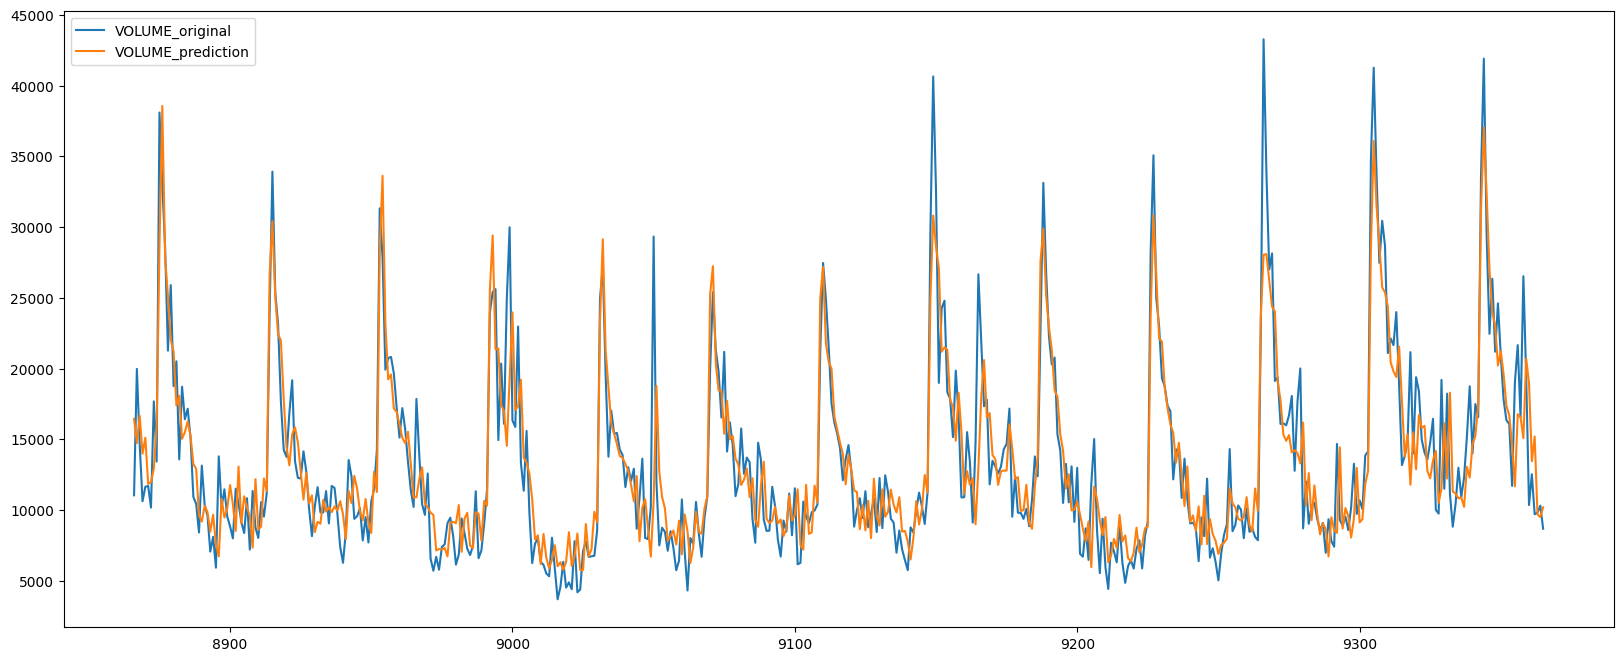

In [ ]:
tdf_test.iloc[:500]['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test.iloc[:500]['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

### Deep Forest (Cascade Forest)

In [ ]:
iters = 1
param_grid = {'n_estimators': [3], 'n_trees': [300], 'max_layers': [5]}
for params in ParameterGrid(param_grid):
    r2_ccd, mae_ccd, mape_ccd = 0, 0, 0
    for j in range(iters):
        ccd = CascadeForestRegressor(n_jobs=8, n_estimators=params['n_estimators'], n_trees=params['n_trees'],
                                     max_layers=params['max_layers'], random_state=0, verbose=0)
        ccd.fit(x_train.values, np.ravel(y_train.values))

        prediction_ccd = pd.DataFrame(ccd.predict(x_val), index=x_val.index, columns=['VOLUME_prediction'])

        tdf_val = prediction_ccd.join(df)[['VOLUME_prediction', 'VOLUME_fut_agg', 'VOLUME_fut_orig']].copy(deep=True)
        if df is ts_int_avg:
            tdf_val['VOLUME_prediction'] = tdf_val['VOLUME_prediction'] + tdf_val['VOLUME_fut_agg']
            tdf_val['VOLUME_fut_orig'] = tdf_val['VOLUME_fut_orig'] + tdf_val['VOLUME_fut_agg']
        tdf_val['VOLUME_original'] = tdf_val['VOLUME_fut_orig']

        r2_ccd += r2_score(tdf_val['VOLUME_original'], tdf_val['VOLUME_prediction'])
        mae_ccd += mean_absolute_error(tdf_val['VOLUME_original'], tdf_val['VOLUME_prediction'])
        mape_ccd += mean_absolute_percentage_error(tdf_val['VOLUME_original'], tdf_val['VOLUME_prediction'])

    r2_ccd /= iters
    mae_ccd /= iters
    mape_ccd /= iters
    print(params)
    print('R2, MAE, MAPE:')
    print(r2_ccd, mae_ccd, mape_ccd)

KeyError: "['VOLUME_fut_orig'] not in index"

MAE/StdDev 34.07109336096316
R2, MAE, MAPE:
0.7610880585386557 2273.6149483718746 0.19481978092652683


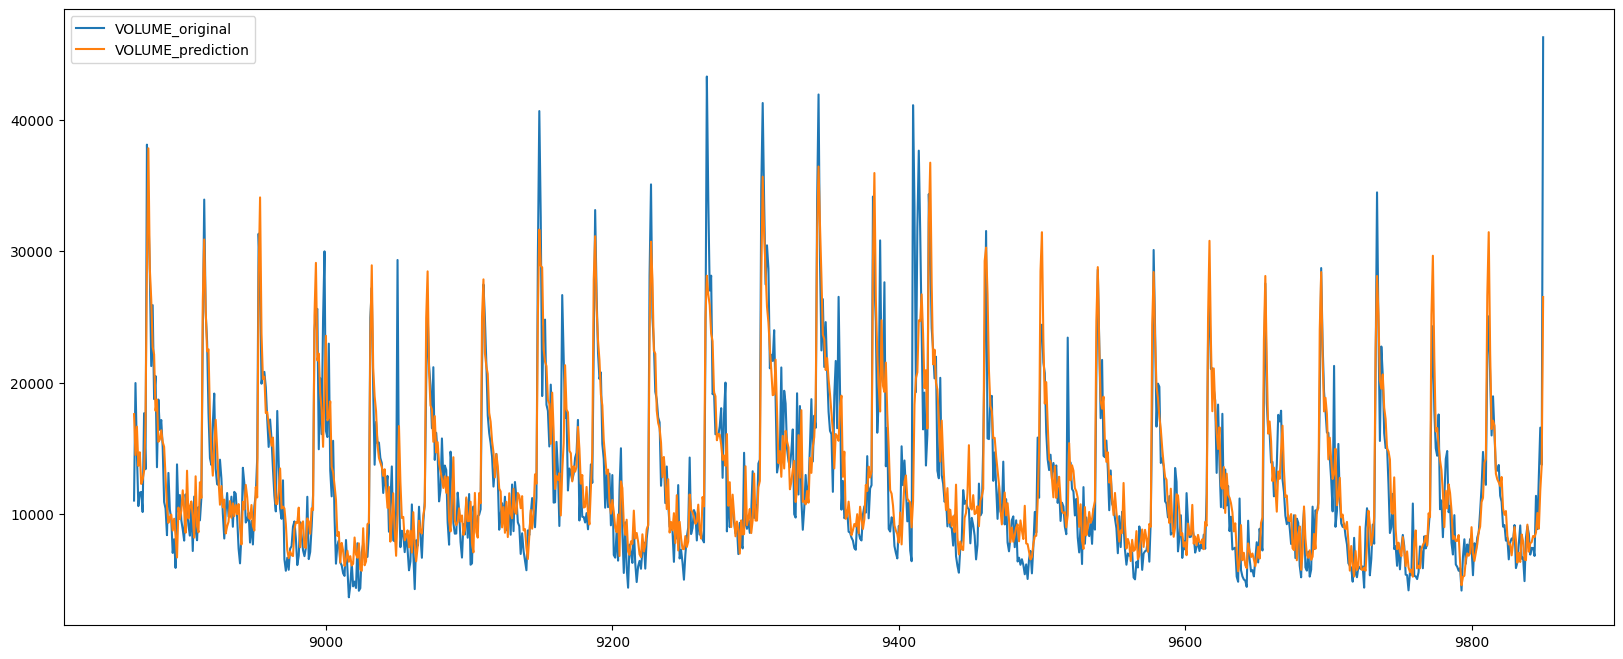

In [ ]:
prediction_ccd = pd.DataFrame(ccd.predict(x_test), index=x_test.index, columns=['VOLUME_prediction'])

if df is ts_int_avg:
        tdf_test = int_avg_inverse_transform(prediction_ccd, df)

tdf_test['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

std_orig = tdf_test.std(numeric_only=True)['VOLUME_original']
r2_ccd = r2_score(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mae_ccd = mean_absolute_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mape_ccd = mean_absolute_percentage_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])

print('MAE/StdDev', mae_ccd / std_orig * 100)
print('R2, MAE, MAPE:')
print(r2_ccd, mae_ccd, mape_ccd)

### Ensemble models results

In [ ]:
print('Baseline:', r2_baseline, mae_baseline, mape_baseline)
print('XGBoost:', r2_xgb, mae_xgb, mape_xgb)
print('CatBoost:', r2_cat, mae_cat, mape_cat)
print('DNN:', r2_dnn, mae_dnn, mape_dnn)
print('Cascade Forest:', r2_ccd, mae_ccd, mape_ccd)

# top5
# XGBoost: 0.7689375652096523 2190.795915744587 0.1849430205251562
# CatBoost: 0.760655429461226 2158.092597354193 0.17494192002159956
# DNN: 0.767989777416128 2204.4669374321725 0.18752189442551204
# Cascade Forest: 0.7542401736538584 2298.910481098774 0.1949189289995071

# top10 (got a small improvement)
# XGBoost: 0.7695877910075168 2195.956998016342 0.18586190560772214
# CatBoost: 0.7629795586352154 2142.4878982744 0.17289897562104875
# DNN: 0.7697058591911983 2199.284935822176 0.1867944133714173
# Cascade Forest: 0.7647832231900624 2253.627064917865 0.1924422866908617

# top15 (+- the same)
# XGBoost: 0.7698596417301481 2198.215633991856 0.1858949535648368
# CatBoost: 0.7612830329041064 2149.4252954293506 0.17389728267219728
# DNN: 0.7709973843880328 2199.0978051101897 0.1872314682400713
# Cascade Forest: 0.7633548771983011 2253.218309964715 0.19230613949193562

# top20 (got a bit worse)
# XGBoost: 0.7693231462036116 2204.1117799637063 0.1861360571642682
# CatBoost: 0.7603969751664602 2150.820487838526 0.17355919178458487
# DNN: 0.7705077028895645 2209.5335781090785 0.18850143300092984
# Cascade Forest: 0.7610880585386557 2273.6149483718746 0.19481978092652677

Baseline: 0.632815109907548 2708.410152284264 0.2167638107543498
XGBoost: 0.7693231462036116 2204.1117799637063 0.1861360571642682
CatBoost: 0.7603969751664602 2150.820487838526 0.17355919178458487
DNN: 0.7704816193216693 2210.8408405063155 0.18872345058281478
Cascade Forest: 0.7610880585386557 2273.6149483718746 0.19481978092652683


# General results